This file will contain our experiments and a guide for understanding the output. **The full report is available here**: https://prabhatnagarajan.github.io/docs/Convex_Optimization__Final_Project.pdf. *The report is our primary source of explanation.*

To understand our problem setting, please see Sections 1, 2.1, 2.2, and 2.3. 

Let's get started! First, we'll import whatever we find necessary.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

print("Done importing")

Done importing


Let's optimize general convex functions. In order to do this, recall that we need a gradient estimator. The next few cells contain our implementation of a spherical gradient estimator. 

First, we'll have to sample from a sphere and a ball. This algorithm is very similar to Algorithm 2 in Section 2.4.1. Note that with a few minor modifications, we could have used an ellipsoidal sampler. More details can be found in Section 2.4.2.

In [0]:
def sample_from_sphere(d):
  p = np.zeros(d)
  theta = np.random.uniform(0, 2 * np.pi, d)
  p[0] = np.cos(theta[0])
  for i in range(1, d - 1):
    p[i] = p[i - 1] * np.cos(theta[i]) * np.sin(theta[i - 1]) / np.cos(theta[i - 1])
  p[d - 1] = 1
  for theta_i in theta[:-1]:
    p[d - 1] *= np.sin(theta_i)
  return p

def sample_from_ball(d):
  r = np.random.uniform(0, 1, 1)
  p = sample_from_sphere(d)
  return r * p



To check that our functions return valid samples, we can run the below cell. Observe that if valid samples are returned, then they must have the correct distribution as argued in 2.4.1 of the report. 

In [21]:
def check_sampler():
  # these are parameters for the experiment. Change them to whatever.
  # note that we only need to check the spherical sampler
  d = 20
  runs = 100
  
  samples = [sample_from_sphere(d) for i in range(runs)]
  
  # check that all the samples lie on the sphere
  counter = 0
  for sample in samples:
    r = 0
    for coordinate in sample:
      r += np.square(coordinate)
    if r <= 0.99 or r >= 1.01:
      print("invalid sample")
      print(sample)
      print(counter)
      return
    counter += 1
  
check_sampler()
print("Done checking sampler")

Done checking sampler


We're now ready to implement our online gradient descent algorithm. We thus begin our experimentation. This section of the notebook expands on ideas discussed in Section 3 of our report.

Here, we consider a $l^1$-regularized least squares problem. Given some regularization parameter $\lambda$, $x \in \mathbb{R}^d$, and $m$ measurements of $A_i^Tx + b$, we can write our problem as:

\begin{align*}
  \min &\ \frac{1}{2}\left\lVert Ax - y\right\rVert_2^2 + \lambda\left\lVert x\right\rVert_1
\end{align*}

It's conceivable that $m$ is sufficiently large that we can't load all of $A$ into memory at once. Instead, we might load some subsets of the observations and $A_i$s into memory at each step in our optimization process. Furthermore, suppose that we don't have access to a gradient oracle; we only have access to the actual loss values instead.

Observe that this problem can now be solved using our BCO model. At each timestep, the adversary can inflict some loss that is based on some subset of the measurements contained in $A$. Note that this is similar to the idea of "minibatch" gradient descent. This is the only feedback we receive, and we will use this to compute our gradient estimates. We then use our gradient estimate to compute our update and repeat.

Below, we set up our problem and data.

In [121]:
# feel free to change these parameters. 
d = 50
m = 50
# let's make the vector k-sparse. this might allow us to explore the problem
# in the sparse setting where m << d
k = 5
  
# regularization weight
lam = 2.5 

noise_std = np.sqrt(0.1)

# note that there are nCr(m, batch_size) possible adversary functions.
batch_size = 1

def get_supports(computed_b):
  threshold = 0.4
  ans = []
  for i in range(len(computed_b)):
    if computed_b[i] > threshold:
      ans.append((i, round(float(computed_b[i]), 2)))
  return ans

A = np.random.normal(0, 1, (m, d))
x_true = np.zeros((d, 1))
nonzero_indices = random.sample(range(d), k)
for i in nonzero_indices:
  x_true[i] = 1
  
b = np.random.normal(0, noise_std, (m, 1))
y = np.dot(A, x_true) + b
  
print("Generated problem data")
print(get_supports(x_true))

Generated problem data
[(0, 1.0), (16, 1.0), (23, 1.0), (25, 1.0), (34, 1.0)]


For simplicity, we suppose we're facing an oblivious adversary. That is, our adversary does not know what the player is currently playing or has played in the past. It thus suffices to select a random minibatch as our loss for that timestep. We can now implement our adversary loss below. We also implement the complete loss and a subgradient function in case any of our other evaluations use these.

In [122]:
def adversary_params():
  indices = random.sample(range(m), batch_size)
  Am = []
  for i in indices:
    Am.append(A[i])
  Am = np.array(Am)
  ym = []
  for i in indices:
    ym.append(y[i])
  ym = np.array(ym)
  return Am, ym

def partial_loss(Am, ym, x):
  return 0.5 * np.square(np.linalg.norm(np.dot(Am, x) - ym)) + lam * np.linalg.norm(x, 1)

def complete_loss(x):
  return 0.5 * np.square(np.linalg.norm(np.dot(A, x) - y)) + lam * np.linalg.norm(x, 1)

def subgradient(x):
  return np.dot(A.T, np.dot(A, x) - y) + lam * np.sign(x)

def gradient(x): # returns a gradient of the differentiable part of f
  return np.dot(A.T, np.dot(A, x) - y)

print("Function definitions complete")
print("Complete loss for true solution: " + str(complete_loss(x_true)))

Function definitions complete
Complete loss for true solution: 14.9655139587


We now have all the information needed to complete a run of our online gradient descent algorithm. Below is our implementation of this algorithm using two-point feedback. We can generate a plot of the solution over the number of iterations we take. As a sanity check, we also include an implementaiton of ISTA (Iterated Soft Thresholding).

In [123]:
num_iterations = 20000

############ ISTA Implementation #####################
def soft_threshold(l, x):
  ans = []
  for i in range(len(x)):
    if x[i] > l:
      ans.append(float(x[i] - l))
    elif x[i] < -l:
      ans.append(float(x[i] + l))
    else:
      ans.append(0)
  ans = np.array(ans)
  ans = ans.reshape((len(ans), 1))
  return ans
  
def ista():
  tl = []
  x = 5.0 * np.ones((d, 1))
  for t in range(num_iterations):
    eta = 0.00002
    v = np.dot(A, x) - y
    st_param = x - eta * np.dot(A.T, v)
    x = soft_threshold(lam * eta, st_param)
    diff = x - x_true
    dist_from_ans = np.linalg.norm(x - x_true)
    tl.append(dist_from_ans)
  return tl
######################################################  
  
# the below two functions will return a sequence of losses for ease of plotting
def two_point_osgd():
  x = 5.0 * np.ones((d, 1))
  eta = 0.00002
  delta = 0.0001
  loss_sequence = []
  grad_deviations = []
  grad_dots = []
  regret = []
  regret.append(0)
  for t in range(num_iterations):
    # we use the actual function here as an implementation detail. recall that
    # our problem model does not use this assumption, however
    Am, ym = adversary_params()
    u = sample_from_sphere(d).reshape((d, 1))
    
    x_plus = x + delta * u
    x_minus = x - delta * u
    
    fxp = partial_loss(Am, ym, x_plus)
    fxm = partial_loss(Am, ym, x_minus)
    
    gradient_estimate = (d / (2 * delta)) * (fxp - fxm) * u
    
    
    # recall that OSGD plays one of these two points at random
    choice = np.random.randint(0, 2)
    if choice == 0:
      x = x_plus
    else:
      x = x_minus
      
    true_gradient = np.dot(Am.T, np.dot(Am, x) - ym) + lam * np.sign(x)
    
    normalized_dot = float(np.dot(gradient_estimate.T, true_gradient))
    normalized_dot /= (np.linalg.norm(gradient_estimate) * np.linalg.norm(true_gradient))
    grad_dots.append(normalized_dot)
    
    x = x - eta * gradient_estimate
    dist_from_ans = np.linalg.norm(x - x_true)
    loss_sequence.append(dist_from_ans)
    grad_deviations.append(np.linalg.norm(gradient_estimate - true_gradient))
    
    r = 0.5 * np.square(np.linalg.norm(np.dot(Am, x) - ym)) + lam * np.linalg.norm(x, 1)
    rb = 0.5 * np.square(np.linalg.norm(np.dot(Am, x_true) - ym)) + lam * np.linalg.norm(x_true, 1)
    regret.append(regret[-1] + r - rb)
  return loss_sequence, grad_deviations, grad_dots, regret
  
def one_point_osgd():
  x = 5.0 * np.ones((d, 1))
  eta = 0.0000002
  delta = 5.0 * d
  loss_sequence = []
  grad_deviations = []
  grad_dots = []
  regret = []
  regret.append(0)
  for t in range(num_iterations):
    # we use the actual function here as an implementation detail. recall that
    # our problem model does not use this assumption, however
    Am, ym = adversary_params()
    u = sample_from_sphere(d).reshape((d, 1))
    
    x_plus = x + delta * u
    
    fxp = partial_loss(Am, ym, x_plus)
    
    gradient_estimate = (d / (delta)) * fxp * u
    
    true_gradient = np.dot(Am.T, np.dot(Am, x) - ym) + lam * np.sign(x)
    
    normalized_dot = float(np.dot(gradient_estimate.T, true_gradient))
    normalized_dot /= (np.linalg.norm(gradient_estimate) * np.linalg.norm(true_gradient))
    grad_dots.append(normalized_dot)
      
    x = x - eta * gradient_estimate
    dist_from_ans = np.linalg.norm(x - x_true)
    loss_sequence.append(dist_from_ans)
    grad_deviations.append(np.linalg.norm(gradient_estimate - true_gradient))
    
    r = 0.5 * np.square(np.linalg.norm(np.dot(Am, x) - ym)) + lam * np.linalg.norm(x, 1)
    rb = 0.5 * np.square(np.linalg.norm(np.dot(Am, x_true) - ym)) + lam * np.linalg.norm(x_true, 1)
    regret.append(regret[-1] + r - rb)
  return loss_sequence, grad_deviations, grad_dots, regret


print("Iterative algorithm definitions complete")

Iterative algorithm definitions complete


Now that we've defined our functions, let's run them and collect some data. The below code does this.

---Parameter list---
Batch size            : 1
dim(x)                : 50
Number of measurements: 50


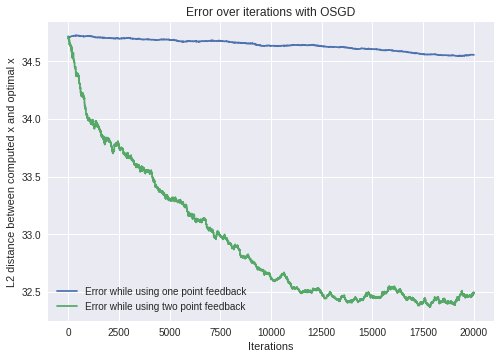

In [124]:
plt.title("Error over iterations with OSGD")
plt.xlabel("Iterations")
plt.ylabel("L2 distance between computed x and optimal x")

loss_sequence_one, grad_deviations_one, grad_dots_one, regret_one = one_point_osgd()
plt.plot(loss_sequence_one, label = "Error while using one point feedback")

loss_sequence_two, grad_deviations_two, grad_dots_two, regret_two = two_point_osgd()
plt.plot(loss_sequence_two, label = "Error while using two point feedback")

# uncomment the below to compare against ISTA
# loss_sequence_three = ista()
# plt.plot(loss_sequence_three, label = "Error while using ISTA")

print("---Parameter list---")
print("Batch size            : " + str(batch_size))
print("dim(x)                : " + str(d))
print("Number of measurements: " + str(m))

plt.legend()
plt.show()

To evaluate the gradient estimators, we can continually measure the $l^2$ distance between the gradient estimate and the true gradient. This information was recorded in the previous cell; to view it, run the below plotting cell. 

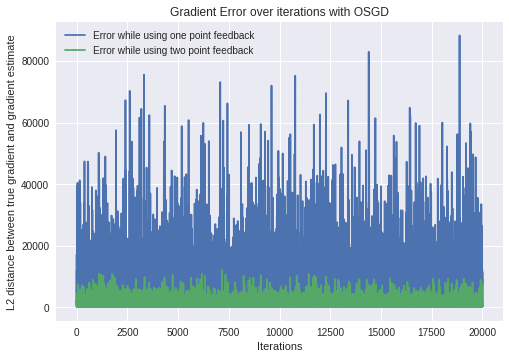

In [125]:
plt.title("Gradient Error over iterations with OSGD")
plt.xlabel("Iterations")
plt.ylabel("L2 distance between true gradient and gradient estimate")

# uncomment the commented lines to get histograms instead

# plt.hist(grad_deviations_one, label = "Error while using one point feedback", bins = "auto")
plt.plot(grad_deviations_one, label = "Error while using one point feedback")

# plt.hist(grad_deviations_two, label = "Error while using two point feedback", bins = "auto")
plt.plot(grad_deviations_two, label = "Error while using two point feedback")

plt.legend()
plt.show()

Although the absolute error between the gradients may be fairly high, it's also enlightening to observe the directional deviation. In particular, if our gradient points in the correct direction, we could still have an algorithm making "productive" iterations (even if these iterations are incredibly small). On the other hand, the $l^2$ distance between the true gradient and the gradient estimate could be fairly small even if they point in opposite directions.

Below, we look at the directional deviations over time.

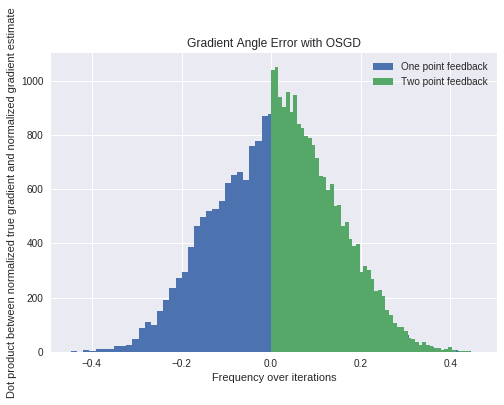

In [126]:
plt.title("Gradient Angle Error with OSGD")
plt.xlabel("Frequency over iterations")
# plt.xlabel("Iterations")
plt.ylabel("Dot product between normalized true gradient and normalized gradient estimate")

# uncomment the commented lines to get plots over time instead

plt.hist(grad_dots_one, label = "One point feedback", bins = "auto")
# plt.plot(grad_dots_one, label = "One point feedback")

plt.hist(grad_dots_two, label = "Two point feedback", bins = "auto")
# plt.plot(grad_dots_two, label = "Two point feedback")

plt.legend()
plt.show()

Importantly, observe that under the two point feedback model, our dot product rarely drops below $0$. This implies that we rarely move in an incorrect direction in our two point model. In contrast, the one point model quite often makes incorrect moves as evidenced by the negative dot products. 

These results raise an interesting theoretical question. Is it possible to prove that our gradient estimate $\tilde{g_t}$ under the two point feedback model always points in the correct direction (similar to $g_t$)? Similarly, can we find $\mathbb{E}[\tilde{g_t}^Tg_t]$ under the one point model (the empirical results suggest that this is $0$)? Answering this question will definitely yield better insight into these results.

We can also record the regret. Below, we graph this.

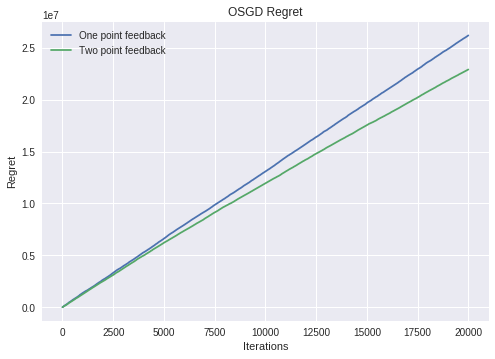

In [127]:
plt.title("OSGD Regret")
plt.xlabel("Iterations")
plt.ylabel("Regret")

plt.plot(regret_one, label = "One point feedback")

plt.plot(regret_two, label = "Two point feedback")

plt.legend()
plt.show()

Recall that our regret bounds stated $O(n^{3/4})$ for the one point model and $O(\sqrt{n})$ for the two point model. The graphs above appear to confirm similar bounds, potentially implying tightness under this problem setting. This does not demonstrate that the bounds are tight under all problem scenarios, however. It would be interesting to run these algorithms on different loss functions and observe the tightness of these bounds (or better performance under certain conditions). 

To view further theoretical directions motivated from these experimental results, please see Section 3.1 of our report.